# Opimizers

## Minimizing a convex simple parablic function

In [1]:
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
def func1(X, loc=(0, 0)):
    return (X - loc[0])**2 + loc[1]

In [3]:
X = np.linspace(-10, 13, 50, dtype=float)
shift = (1.5, 5.0)
Y = func1(X, loc=shift)

In [4]:
def plot_func(X, Y, p=None):
    plt.plot(X, Y, 'b-')
    if p:
        plt.plot(p[0], p[1], 'go')
    plt.title(label='func1', fontsize=14, pad=10, color='black')
    plt.ylim(Y.min()-10, Y.max()+10)
    plt.xlim(X.min()-2, X.max()+2)

In [5]:
init_x = 10
init_y = func1(init_x, loc=shift)

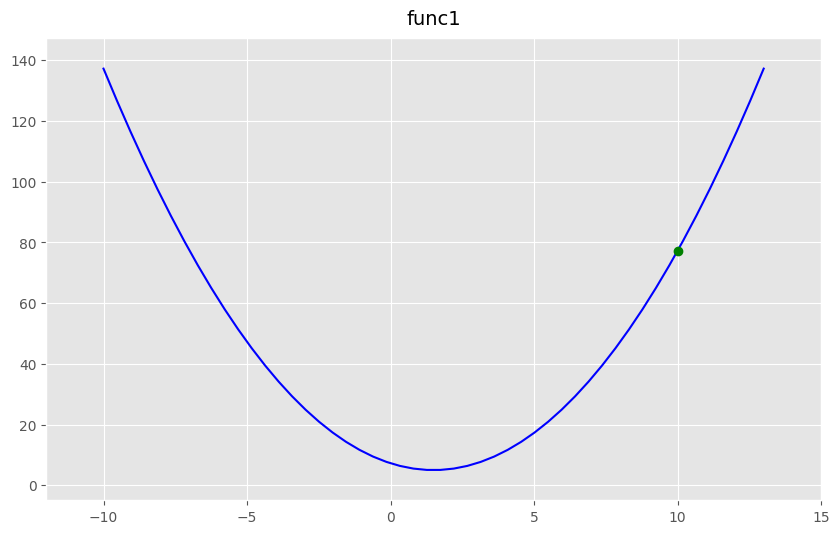

In [6]:
plot_func(X, Y, p=(init_x, init_y))

In [7]:
res = spo.minimize(func1, init_y, args=(shift,), method='SLSQP', options={'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.0
            Iterations: 2
            Function evaluations: 5
            Gradient evaluations: 2


In [8]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.0
       x: [ 1.500e+00]
     nit: 2
     jac: [ 0.000e+00]
    nfev: 5
    njev: 2

In [9]:
print('Optimized point:', (res.x, res.fun))

Optimized point: (array([1.5]), 5.0)


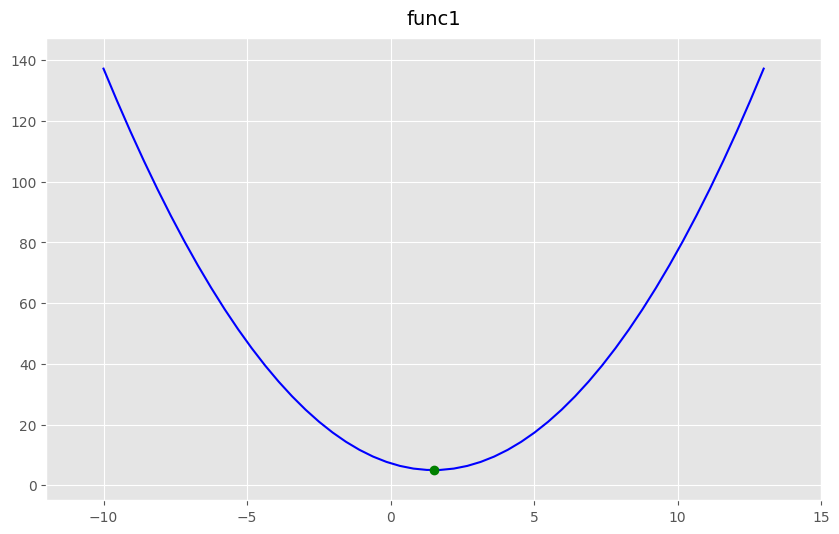

In [10]:
plot_func(X, Y, p=(res.x, res.fun))

## Building a parametrized model for a linear 2D function

In [11]:
import pandas as pd
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [12]:
def error(line, data): # error function
    """
    Compute error between given line model and observed data.
    
    Parameters
    ----------
    line: tuple/list/array (C0, C1) where C0 is the slope and C1 is the Y-intercept
    data: 2D array where each row is a point (x, y)
    
    Returns
    -------
    err (int): error as a single real value.
    """
    # Metric: Sum of squared Y-axis differences
    err = np.sum((data[:, 1] - (line[0] * data[:, 0] + line[1])) ** 2)
    return err

In [13]:
def fit_line(data, error_func, show=False):
    """Fit a line to given data, using a supplied error function.

    Parameters
    ----------
    data: 2D array where each row is a point (X0, Y)
    error_func: function that computes the error between a line and observed data

    Returns line that minimizes the error function.
    """
    # Generate initial guess for line model
    # slope = 0, intercept = mean(y values)
    l = np.array([0, np.mean(data[:, 1])], dtype=float)
    
    # Plot initial guess (optional)
    x_ends = np.array([-5, 5], dtype=float)
    if show:
        plt.plot(x_ends, l[0] * x_ends + l[1], 'k--', linewidth=2.0, label='Initial guess')
    
    # Call optimizer to minimize error function
    result = spo.minimize(error_func, l, args=(data,), method='SLSQP', options={'disp': True})
    return result.x

In [14]:
def test_run(show=False):
    # Define original line
    # these values are what we expect the optimizer to derive by going through the data
    l_orig = np.array([4, 2], dtype=float)
    print(f'Original line: C0 = {l_orig[0]}, C1 = {l_orig[1]}')
    
    # data construction based on our original line
    Xorig = np.linspace(0, 10, 21)
    Yorig = l_orig[0] * Xorig + l_orig[1]
    if show:
        plt.plot(Xorig, Yorig, 'b--', linewidth=2, label='Original line')
    
    # Generate noisy data points => Data + noise
    noise_sigma = 3.0
    noise = np.random.normal(0, noise_sigma, Yorig.shape)
    data = np.array([Xorig, Yorig + noise]).T
    if show:
        plt.plot(data[:, 0], data[:, 1], 'go', ms=6, mfc='none', label='Data points')
    
    # Try to fit a line to this data
    l_fit = fit_line(data, error, show)
    print(f'Fitted line:\nC0 = {l_fit[0]}, C1 = {l_fit[1]}')
    if show:
        plt.plot(data[:, 0], l_fit[0] * data[:, 0] + l_fit[1], 'm--', linewidth=2, label='Fitted line')

    plt.legend()
    plt.show()

Original line: C0 = 4.0, C1 = 2.0
Optimization terminated successfully    (Exit mode 0)
            Current function value: 148.1305471578518
            Iterations: 5
            Function evaluations: 19
            Gradient evaluations: 5
Fitted line:
C0 = 3.6786516675522587, C1 = 3.578617331633955


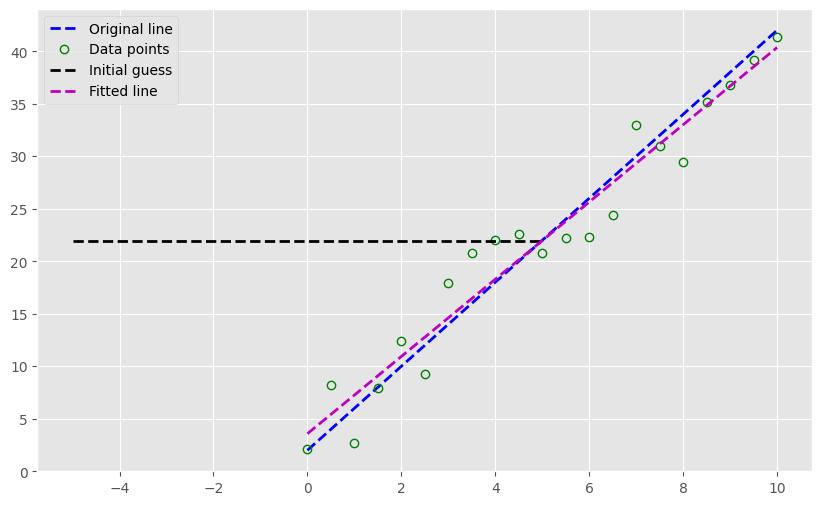

In [15]:
test_run(show=True)

## Building a parametrized model for a convex polynomial function

In [16]:
import pandas as pd
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [17]:
def error_poly(C, data): # error function
    """
    Compute error between given polynomial and observed data.
    Inputs
        C   : numpy.poly1d object or equivalent array representing polynomial coefficients
        data: 2D array where each row is a point (x, y)
    Outputs
        err (int) = error as a single real value.
    """
    # Metric: Sum of squared Y-axis differences
    err = np.sum((data[:, 1] - np.polyval(C, data[:, 0])) ** 2)
    return err

In [18]:
def fit_poly(data, error_func, degree, show=False):
    """Fit a polynomial to given data, using a supplied error function.
    
    Parameters
    ----------
    data: 2D array where each row is a point (X0, Y)
    error_func: function that computes the error between a polynomial and observed data
    
    Returns polynomial that minimizes the error function.
    """
    # Generate initial guess for line model (all coeffs = 1)
    Cguess = np.poly1d(np.ones(degree + 1, dtype=float))
    if show:
        plt.plot(data[:, 0], np.polyval(Cguess, data[:, 0]), 'k--', linewidth=2, label='Initial guess')
    
    # Call optimizer to minimize error function
    result = spo.minimize(error_func, Cguess, args=(data,), method = 'SLSQP', options={'disp': True})
    # convert optimal result into a poly1d object and return
    return np.poly1d(result.x)

In [19]:
def test_run(show=False):
    # Define original line a polynomial of degree 2
    # these values are what we expect the optimizer to derive by going through the data
    l_orig = np.array([1.5, -10, -5, 60, 50], dtype=float)
    print(f'Original coefficients: {l_orig}')
    
    # data construction based on our line
    Xorig = np.linspace(-10, 10, 30)
    # the exponents belong to the Xorig values. l_orig are the co-efficients
    Yorig = np.polyval(l_orig, Xorig)
    if show:
        plt.plot(Xorig, Yorig, 'b--', linewidth=2, label='Original curve')
    
    # Generate noisy data points => Data + noise
    noise_sigma = 100.0
    noise = np.random.normal(-noise_sigma, noise_sigma, Yorig.shape)
    data = np.asarray([Xorig, Yorig + noise]).T
    if show:
        plt.plot(data[:, 0], data[:, 1], 'go', ms=6, mfc='none', label='Data points')
    
    # Try to fit a polynomial to this data
    degree = l_orig.shape[0] - 1
    l_fit = fit_poly(data, error_poly, degree, show)
    print(f'Fitted coefficients including random noise between open interval ({-noise_sigma}, {noise_sigma})):\n{l_fit}')
    if show:
        plt.plot(data[:, 0], np.polyval(l_fit, data[:, 0]), 'm--', linewidth=2, label='Fitted curve')

    plt.legend()
    plt.show()

Original coefficients: [  1.5 -10.   -5.   60.   50. ]
Optimization terminated successfully    (Exit mode 0)
            Current function value: 295478.5274169831
            Iterations: 9
            Function evaluations: 88
            Gradient evaluations: 9
Fitted coefficients including random noise between open interval (-100.0, 100.0)):
       4         3         2
1.523 x - 10.03 x - 6.848 x + 65.37 x - 53.13


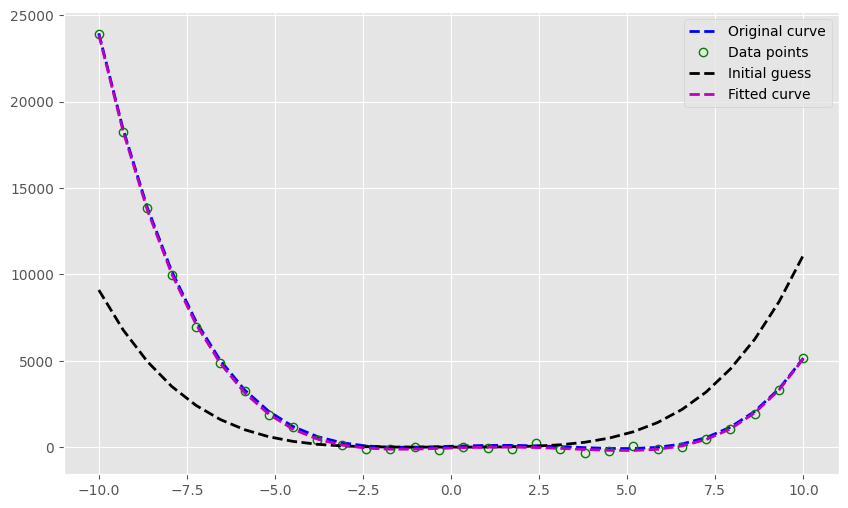

In [20]:
test_run(show=True)

---